# Geographic Transforms and Projections

### Loading the GEOS data 

For this analysis we'll be loading some global climate data into yt. A frontend does not exist for this dataset yet, so we'll load it in as a uniform grid with netcdf4.

In [1]:
import pprint
import yt
import numpy as np
import re
import netCDF4 as nc4

In [2]:
n = nc4.Dataset("~/yt_data/geos/2015/GEOS.fp.asm.inst3_3d_aer_Nv.20151030_0000.V01.nc4")

Using the loaded data we'll fill arrays with the data dimensions and limits. We'll also rename `vertical level` to `altitude` to be clearer. 

In [3]:
dims = []
sizes = []
bbox = []
ndims = len(n.dimensions)
for dim in n.dimensions.keys():
    size = n.variables[dim].size
    if size > 1:
        bbox.append([n.variables[dim][:].min(),
                     n.variables[dim][:].max()])
        dims.append(n.variables[dim].long_name)
        sizes.append(size)
dims.reverse()   # Fortran ordering
sizes.reverse()
bbox.reverse()
dims = [f.replace('vertical level', 'altitude') for f in dims]
bbox = np.array(bbox)

We'll also load the data into a container dictionary and create a lookup for the short to the long names 

In [4]:
w_regex = re.compile(r'([a-zA-Z]+)(.*)')
def regex_parser(s):
    try:
        return "**".join(filter(None, w_regex.search(s).groups()))
    except AttributeError:
        return s

In [5]:
data = {}
names = {}
for field, d in n.variables.items():
    if d.ndim != ndims:
        continue
    units = n.variables[field].units
    units =  " * ".join(map(regex_parser, units.split())) 
    data[field] = (np.squeeze(d), str(units))
    names[field] = n.variables[field].long_name.replace("_", " ")

Now the data can be loaded with yt's `load_uniform_grid` function. We also need to say that the geometry is a `geographic` type. This will ensure that the axes created are matplotlib GeoAxes and that the transform functions are available to use for projections. 

In [6]:
ds = yt.load_uniform_grid(data, sizes, 1.0, geometry=("geographic", dims),
                          bbox=bbox)

yt : [INFO     ] 2018-10-23 23:06:20,985 Parameters: current_time              = 0.0
yt : [INFO     ] 2018-10-23 23:06:20,987 Parameters: domain_dimensions         = [  72  721 1152]
yt : [INFO     ] 2018-10-23 23:06:20,988 Parameters: domain_left_edge          = [   1.  -90. -180.]
yt : [INFO     ] 2018-10-23 23:06:20,991 Parameters: domain_right_edge         = [ 72.      90.     179.6875]
yt : [INFO     ] 2018-10-23 23:06:20,994 Parameters: cosmological_simulation   = 0.0


### Default projection with geographic geometry

Now that the data is loaded, we can plot it with a yt SlicePlot along the altitude. This will crate a figure with latitude and longitude as the plot axes and the colormap will correspond to the air density. Because no projection type has been set, the geographic geometry type assumes that the data is of the `PlateCarree` form. The resulting figure will be a `Mollweide` plot. 

yt : [INFO     ] 2018-10-23 23:06:21,441 xlim = -180.000000 179.687500
yt : [INFO     ] 2018-10-23 23:06:21,441 ylim = -90.000000 90.000000
yt : [INFO     ] 2018-10-23 23:06:21,443 xlim = -180.000000 179.687500
yt : [INFO     ] 2018-10-23 23:06:21,444 ylim = -90.000000 90.000000
yt : [INFO     ] 2018-10-23 23:06:21,446 Making a fixed resolution buffer of (('stream', 'AIRDENS')) 800 by 800



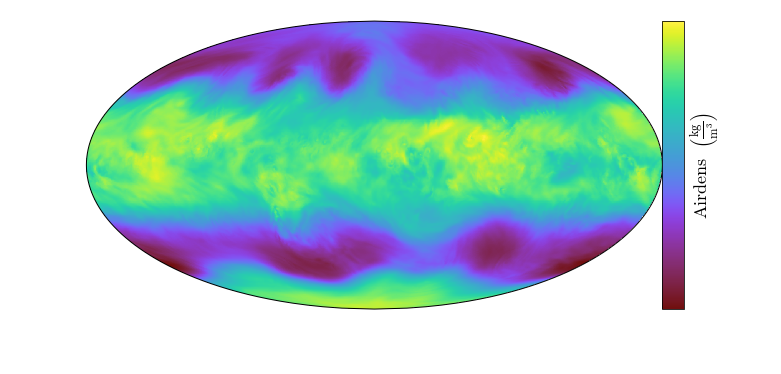

In [7]:
p = yt.SlicePlot(ds, "altitude", 'AIRDENS')
p.show()

Note that this doesn't have a lot of contextual information. We can add annotations for the coastlines just as we would with matplotlib. Before the annotations are set, we need to call `p._setup_plots` to make the axes available for annotation. 

yt : [INFO     ] 2018-10-23 23:06:31,812 xlim = -180.000000 179.687500
yt : [INFO     ] 2018-10-23 23:06:31,813 ylim = -90.000000 90.000000
yt : [INFO     ] 2018-10-23 23:06:31,815 xlim = -180.000000 179.687500
yt : [INFO     ] 2018-10-23 23:06:31,818 ylim = -90.000000 90.000000
yt : [INFO     ] 2018-10-23 23:06:31,819 Making a fixed resolution buffer of (('stream', 'AIRDENS')) 800 by 800



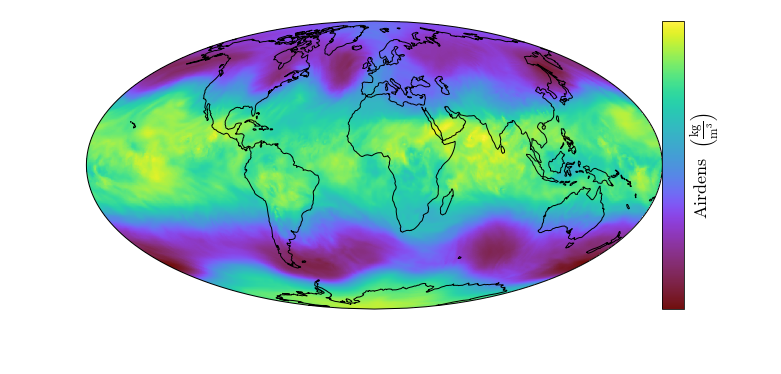

In [8]:
p = yt.SlicePlot(ds, "altitude", 'AIRDENS')
p._setup_plots()
p.plots['AIRDENS'].axes.set_global()
p.plots['AIRDENS'].axes.coastlines()
p.show()

### Using geographic transforms to project data

If a projection other than the default `Mollweide` is desired, then we can pass an argument to the `set_mpl_projection()` function to set a different projection than the default. This will set the projection to a Robinson projection. 

yt : [INFO     ] 2018-10-23 23:06:41,889 xlim = -180.000000 179.687500
yt : [INFO     ] 2018-10-23 23:06:41,889 ylim = -90.000000 90.000000
yt : [INFO     ] 2018-10-23 23:06:41,891 xlim = -180.000000 179.687500
yt : [INFO     ] 2018-10-23 23:06:41,891 ylim = -90.000000 90.000000
yt : [INFO     ] 2018-10-23 23:06:41,892 Making a fixed resolution buffer of (('stream', 'AIRDENS')) 800 by 800



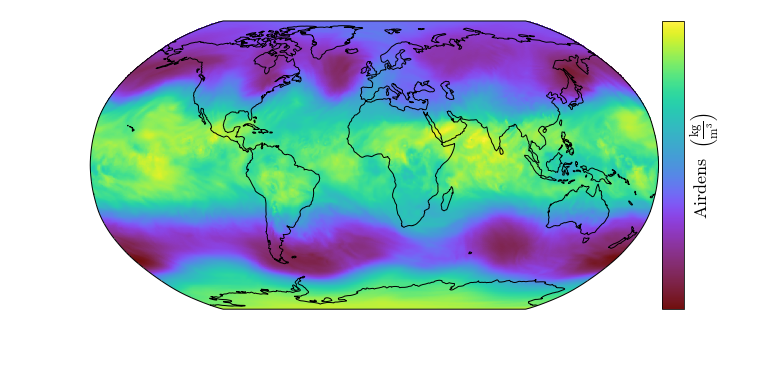

In [9]:
p = yt.SlicePlot(ds, "altitude", 'AIRDENS')
p.set_mpl_projection("Robinson")
p._setup_plots()
p.plots['AIRDENS'].axes.set_global()
p.plots['AIRDENS'].axes.coastlines()
p.show()

`geo_projection` accepts a string or a 2- to 3- length sequenece describing the projection the second item in the sequence are the args and the third item is the kwargs. This can be used for further customization of the projection. 

yt : [INFO     ] 2018-10-23 23:06:52,202 xlim = -180.000000 179.687500
yt : [INFO     ] 2018-10-23 23:06:52,203 ylim = -90.000000 90.000000
yt : [INFO     ] 2018-10-23 23:06:52,204 xlim = -180.000000 179.687500
yt : [INFO     ] 2018-10-23 23:06:52,205 ylim = -90.000000 90.000000
yt : [INFO     ] 2018-10-23 23:06:52,207 Making a fixed resolution buffer of (('stream', 'AIRDENS')) 800 by 800



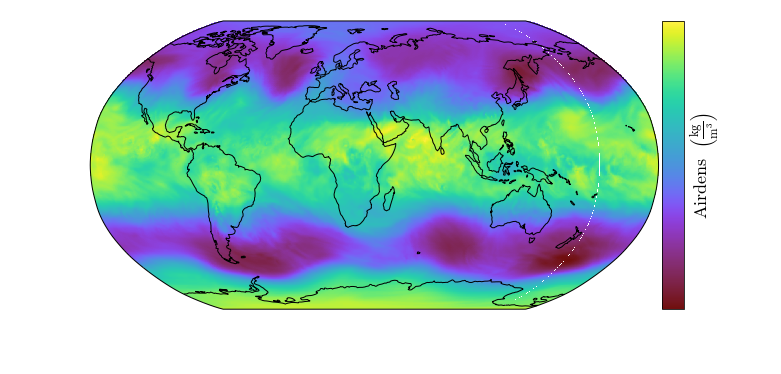

In [10]:
p = yt.SlicePlot(ds, "altitude", 'AIRDENS')
p.set_mpl_projection(("Robinson",(37.5,)))
p._setup_plots()
p.plots['AIRDENS'].axes.set_global()
p.plots['AIRDENS'].axes.coastlines()
p.show()

We don't actually need to keep creating a SlicePlot to change the projection type. We can use the function `set_mpl_projection()` and pass in a string of the transform type that we desire after an existing `SlicePlot` instance has been created. This will set the figure to an `Orthographic` projection. 


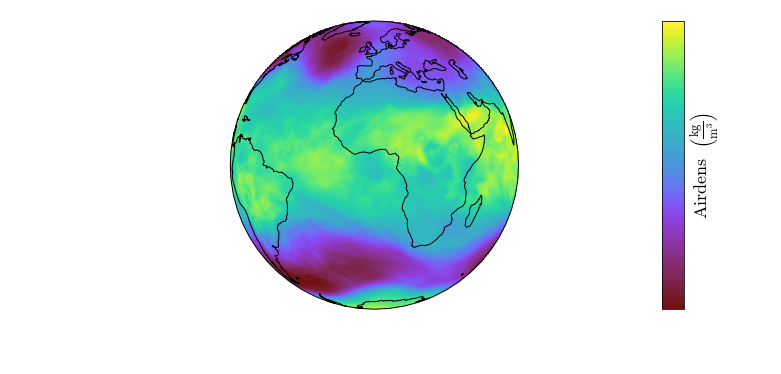

In [11]:
p.set_mpl_projection('Orthographic')
p._setup_plots()
p.plots['AIRDENS'].axes.set_global()
p.plots['AIRDENS'].axes.coastlines()
p.show()

`set_mpl_projection()` can be used in a number of ways to customize the projection type. 
* If a **string** is passed, then the string must correspond to the transform name, which is exclusively cartopy transforms at this time. This looks like: `set_mpl_projection('ProjectionType')`

* If a **tuple** is passed, the first item of the tuple is a string of the transform name and the second two items are args and kwargs. These can be used to further customize the transform (by setting the latitude and longitude, for example. This looks like: 
  * `set_mpl_projection(('ProjectionType', (args)))`
  * `set_mpl_projection(('ProjectionType', (args), {kwargs}))`
* A **transform object** can also be passed. This can be any transform type -- a cartopy transform or a matplotlib transform. This allows users to either pass the same tranform object around between plots or define their own transform and use that in yt's plotting functions. With a standard cartopy transform, this would look like:
  * `set_mpl_projection(cartopy.crs.PlateCarree())`
  
To summarize:
The function `set_mpl_projection` can take one of several input types:
* `set_mpl_projection('ProjectionType')`
* `set_mpl_projection(('ProjectionType', (args)))`
* `set_mpl_projection(('ProjectionType', (args), {kwargs}))`
* `set_mpl_projection(cartopy.crs.MyTransform())`

For example, we can make the same Orthographic projection and pass in the central latitude and longitude for the projection: 


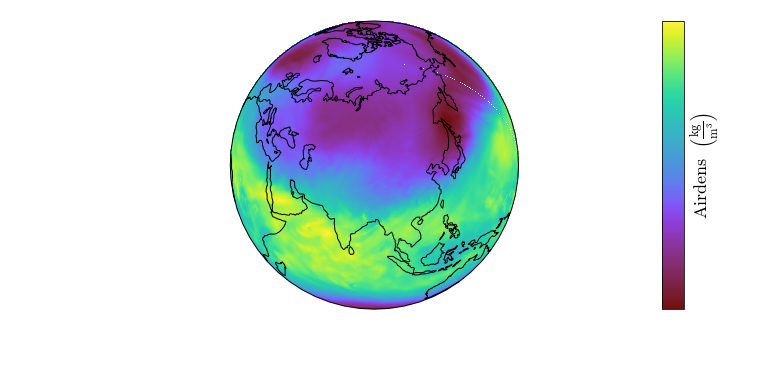

In [12]:
p.set_mpl_projection(('Orthographic', (90, 45)))
p._setup_plots()
p.plots['AIRDENS'].axes.set_global()
p.plots['AIRDENS'].axes.coastlines()
p.show()

Or we can pass in the arguments to this function as kwargs by passing a three element tuple. 


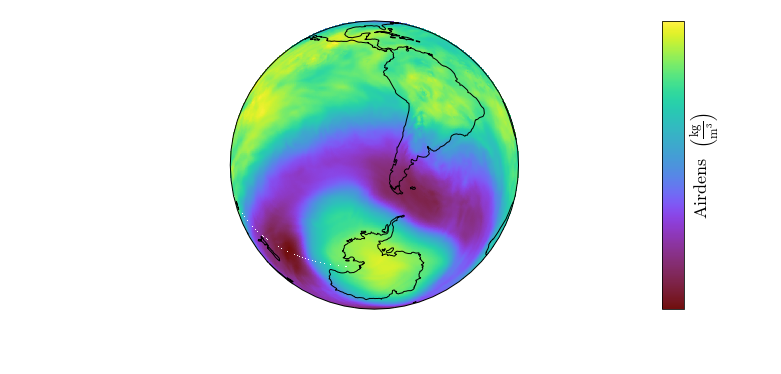

In [13]:
p.set_mpl_projection(('Orthographic', (), {'central_latitude':-45, 'central_longitude':275}))
p._setup_plots()
p.plots['AIRDENS'].axes.set_global()
p.plots['AIRDENS'].axes.coastlines()
p.show()

### A few examples of different projections

This next section will show a few of the different projections that one can use. This isn't meant to be complete, but it'll give you a visual idea of how these transforms can be used to illustrate geographic data for different purposes. 


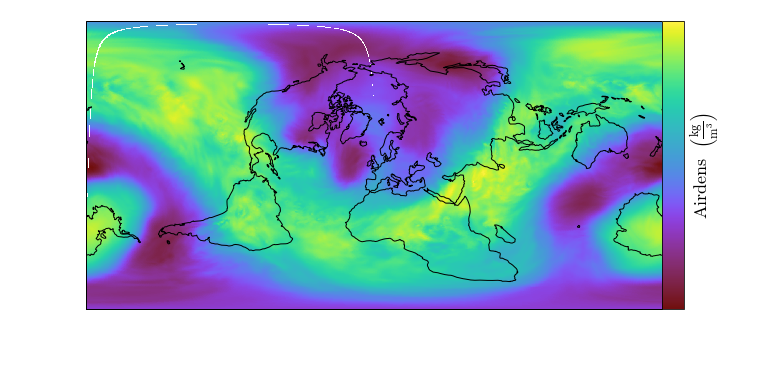

In [14]:
p.set_mpl_projection(('RotatedPole', (177.5, 37.5)))
p._setup_plots()
p.plots['AIRDENS'].axes.set_global()
p.plots['AIRDENS'].axes.coastlines()
p.show()


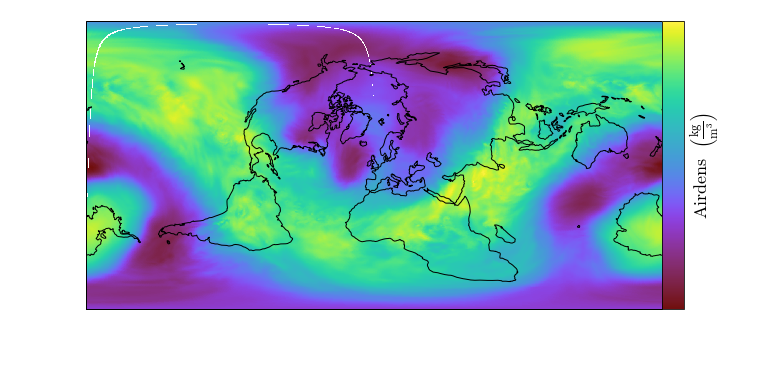

In [15]:
p.set_mpl_projection(('RotatedPole', (), {'pole_latitude':37.5, 'pole_longitude':177.5}))
p._setup_plots()
p.plots['AIRDENS'].axes.set_global()
p.plots['AIRDENS'].axes.coastlines()
p.show()


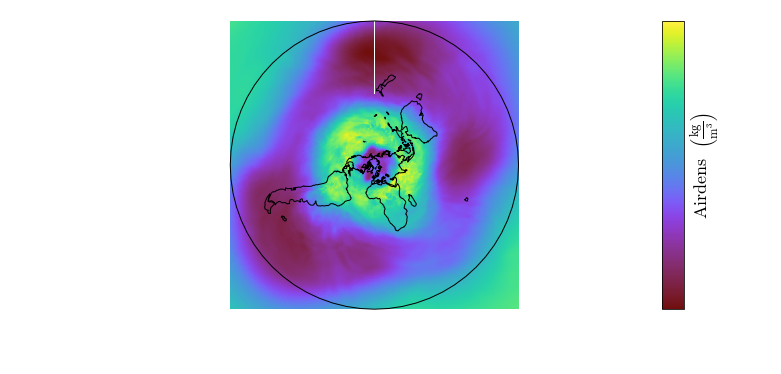

In [16]:
p.set_mpl_projection('NorthPolarStereo')
p._setup_plots()
p.plots['AIRDENS'].axes.set_global()
p.plots['AIRDENS'].axes.coastlines()
p.show()

/Users/madicken/python/anaconda/envs/ytdev/lib/python3.6/site-packages/cartopy/img_transform.py:315: RuntimeWarning: invalid value encountered in greater
  x_extent) > FRACTIONAL_OFFSET_THRESHOLD) |
/Users/madicken/python/anaconda/envs/ytdev/lib/python3.6/site-packages/cartopy/img_transform.py:317: RuntimeWarning: invalid value encountered in greater
  y_extent) > FRACTIONAL_OFFSET_THRESHOLD))



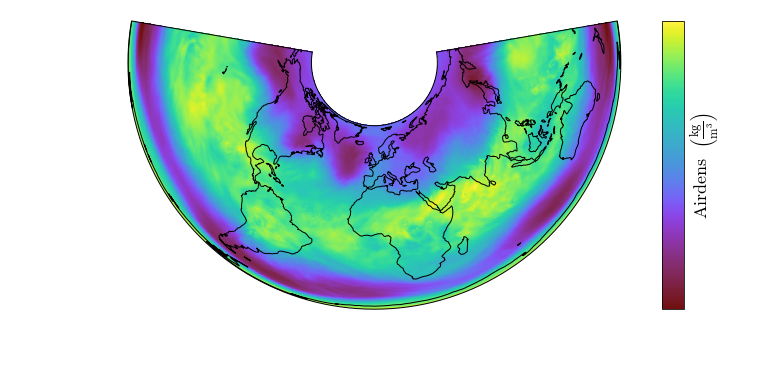

In [17]:
p.set_mpl_projection('AlbersEqualArea')
p._setup_plots()
p.plots['AIRDENS'].axes.set_global()
p.plots['AIRDENS'].axes.coastlines()
p.show()


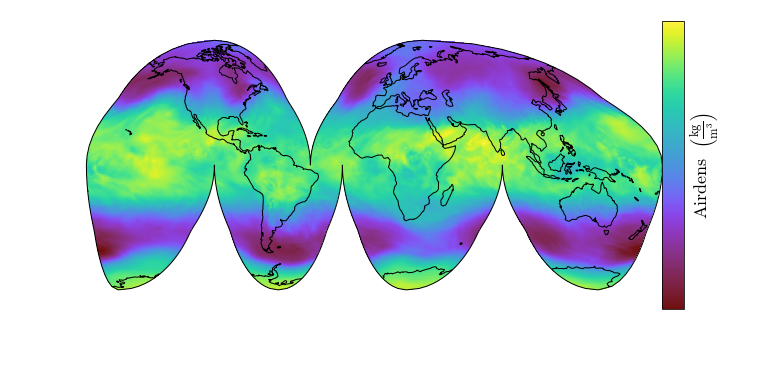

In [18]:
p.set_mpl_projection('InterruptedGoodeHomolosine')
p._setup_plots()
p.plots['AIRDENS'].axes.set_global()
p.plots['AIRDENS'].axes.coastlines()
p.show()


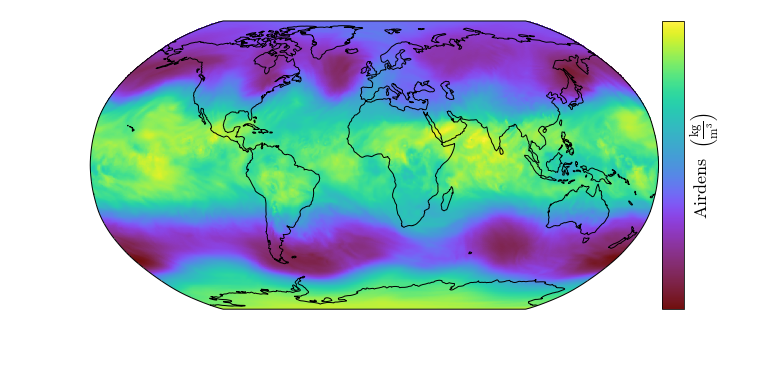

In [19]:
p.set_mpl_projection('Robinson')
p._setup_plots()
p.plots['AIRDENS'].axes.set_global()
p.plots['AIRDENS'].axes.coastlines()
p.show()


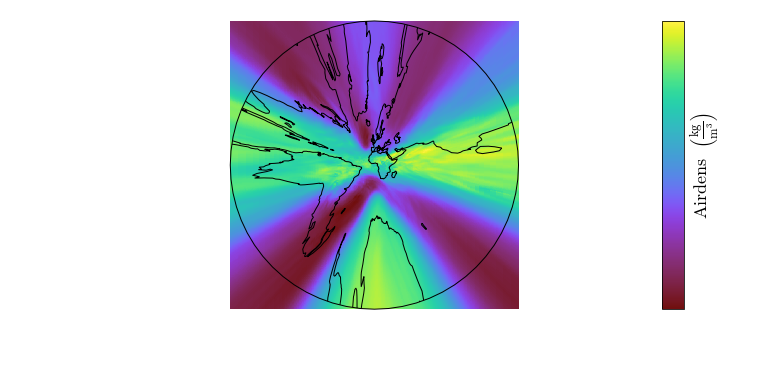

In [20]:
p.set_mpl_projection('Gnomonic')
p._setup_plots()
p.plots['AIRDENS'].axes.set_global()
p.plots['AIRDENS'].axes.coastlines()
p.show()

### Modifying the data transform

While the data projection modifies how the data is displayed in our plot, the data transform describes the coordinate system that the data is actually described by. By default, the data is assumed to have a `PlateCarree` data transform. If you would like to change this, you can access the dictionary in the coordinate handler and set it to something else. The dictionary is structured such that each axis has its own default transform, so be sure to set the axis you intend to change. This next example changes the transform to a Miller type. Because our data is not in Miller coordiantes, it will be skewed. 

yt : [INFO     ] 2018-10-23 23:07:33,369 xlim = -180.000000 179.687500
yt : [INFO     ] 2018-10-23 23:07:33,369 ylim = -90.000000 90.000000
yt : [INFO     ] 2018-10-23 23:07:33,371 xlim = -180.000000 179.687500
yt : [INFO     ] 2018-10-23 23:07:33,372 ylim = -90.000000 90.000000
yt : [INFO     ] 2018-10-23 23:07:33,374 Making a fixed resolution buffer of (('stream', 'AIRDENS')) 800 by 800



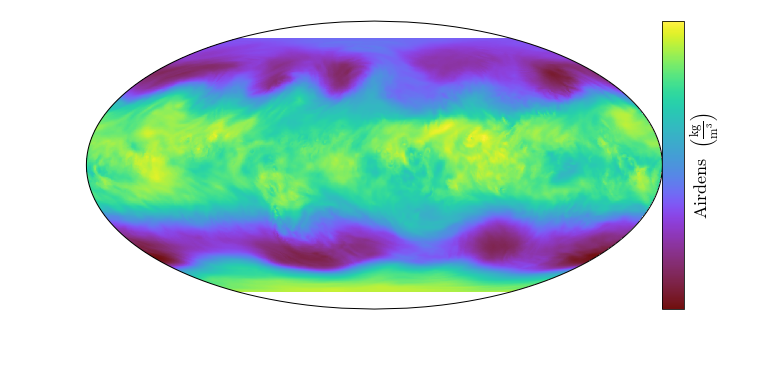

In [21]:
ds.coordinates.data_transform["altitude"]="Miller"
p = yt.SlicePlot(ds, "altitude", 'AIRDENS')
p.plots['AIRDENS'].axes.set_global()
p.plots['AIRDENS'].axes.coastlines()
p.show()

Because the transform type shouldn't change as we make subsequent figures, once it is changed it will be the same for all other figures made with the same dataset object. Note that this particular dataset is not actually in a Miller system, which is why the data now doesn't span the entire globe. Setting the new projection to Robinson results in Miller-skewed data in our next figure. 


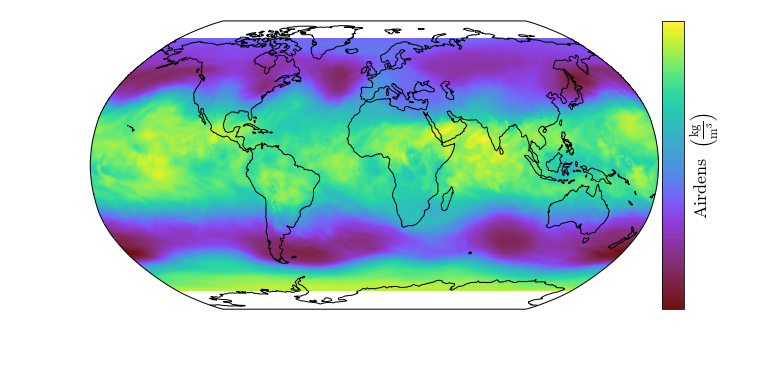

In [22]:
p.set_mpl_projection('Robinson')
p._setup_plots()
p.plots['AIRDENS'].axes.set_global()
p.plots['AIRDENS'].axes.coastlines()
p.show()